## Salamandra 7B Finetuning

In [1]:
pip install -U numpy pandas codecarbon enum34 mkl jupyterlab tqdm openpyxl torch transformers accelerate deepspeed datasets sentencepiece transformers[sentencepiece] peft bitsandbytes

Note: you may need to restart the kernel to use updated packages.


In [2]:
pue = 1.12
country_iso_code = 'ESP'
region='ESP'
cloud_provider='gcp'
cloud_region='europe-southwest1'
country_2letter_iso_code = 'ES'

# Para este caso, únicamnete se definirá el nombre del fichero de salida. Si el usuario lo desea, puede añadir otros.
output_file = 'test_emissions_7b_finetuning_text2sql.csv'

In [3]:
from codecarbon import OfflineEmissionsTracker
tracker = OfflineEmissionsTracker(
        country_iso_code=country_iso_code,
        region=region,
        cloud_provider=cloud_provider,
        cloud_region=cloud_region,
        country_2letter_iso_code=country_2letter_iso_code,
        pue=pue,
        output_file = output_file
)

[codecarbon INFO @ 22:10:17] offline tracker init
[codecarbon WARNING @ 22:10:17] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:10:17] [setup] RAM Tracking...
[codecarbon INFO @ 22:10:17] [setup] CPU Tracking...
[codecarbon WARNING @ 22:10:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 22:10:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) Platinum 8370C CPU @ 2.80GHz
[codecarbon WARNING @ 22:10:18] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 22:10:18] [setup] GPU Tracking...
[codecarbon INFO @ 22:10:18] No GPU found.
[codecarbon INFO @ 22:10:18] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: cpu_load
                GPU Tracking Method

In [4]:
# Inicio del proceso de medición
tracker.start()

### Empieza la parte de entrenamiento

In [5]:
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, TrainerCallback, DataCollatorForSeq2Seq,
    get_linear_schedule_with_warmup, BitsAndBytesConfig, StoppingCriteria, StoppingCriteriaList, set_seed
)
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch
import os
import random
import numpy as np

SEED = 42
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/anaconda/envs/azureml_py310_sdkv2/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


In [6]:
class StopOnTokens(StoppingCriteria):
    """
    Halt generation as soon as the model emits any of the given token IDs.
    """
    def __init__(self, stop_token_ids: list[int]):
        super().__init__()
        self.stop_token_ids = set(stop_token_ids)

    def __call__(self, input_ids, scores, **kwargs):
        # stops if *any* sequence in the batch just produced a stop token
        last_tokens = input_ids[:, -1].tolist()
        return any(tok in self.stop_token_ids for tok in last_tokens)

In [7]:
MODEL_NAME = "BSC-LT/salamandra-7b-instruct"
STOP_TOKEN = ";" # Useful because we can make SQL queries to end with ;

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto"  # or simply omit this line if using CPU
)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"], # Use this to get additional precision
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    label_pad_token_id=-100,
)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[codecarbon INFO @ 22:10:33] Energy consumed for RAM : 0.000299 kWh. RAM Power : 62.0 W
[codecarbon INFO @ 22:10:34] Delta energy consumed for CPU with cpu_load : 0.000209 kWh, power : 43.07733333333333 W
[codecarbon INFO @ 22:10:34] Energy consumed for All CPU : 0.000209 kWh
[codecarbon INFO @ 22:10:34] 0.000508 kWh of electricity used since the beginning.
Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s][codecarbon INFO @ 22:10:48] Energy consumed for RAM : 0.000577 kWh. RAM Power : 62.0 W
[codecarbon INFO @ 22:10:49] Delta energy consumed for CPU with cpu_load : 0.000183 kWh, power : 41.0 W
[codecarbon INFO @ 22:10:49] Energy consumed for All CPU : 0.000392 kWh
[codecarbon INFO @ 22:10:49] 0.000969 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:11:03] Energy consumed for RAM : 0.0008

#### Dataset analysis

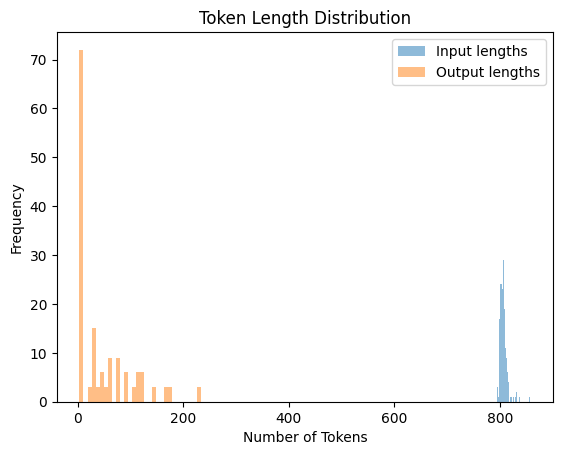

Max input length: 858
Max output length: 233


In [8]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel('Text2SQL_Data.xlsx')
with open('Estructura_Base_de_Datos_Gemini.txt', 'r') as f:
    estructura_sql = ''.join(f.readlines())
input_template = """
### Base de datos:
{estructura_sql}
### Instrucción: {prompt}
### SQL:
""".strip()
df['Prompt'] = df['Prompt'].apply(
    lambda x: input_template.format(estructura_sql=estructura_sql, prompt=x)
)
input_lengths = [len(tokenizer(text)['input_ids']) for text in df['Prompt']]
output_lengths = [len(tokenizer(text)['input_ids']) for text in df['SQL']]

plt.hist(input_lengths, bins=30, alpha=0.5, label='Input lengths')
plt.hist(output_lengths, bins=30, alpha=0.5, label='Output lengths')
plt.legend()
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

print(f"Max input length: {max(input_lengths)}")
print(f"Max output length: {max(output_lengths)}")

#### Dataset tokenizing

In [9]:
from datasets import Dataset, DatasetDict
import pandas as pd

ds = DatasetDict()

df = pd.read_excel('Text2SQL_Data.xlsx')
with open('Estructura_Base_de_Datos_Gemini.txt', 'r') as f:
    estructura_sql = ''.join(f.readlines())
input_template = """
### Base de datos:
{estructura_sql}
### Instrucción: {prompt}
### SQL:
""".strip()
df['Prompt'] = df['Prompt'].apply(
    lambda x: input_template.format(estructura_sql=estructura_sql, prompt=x)
)
ds['train'] = Dataset.from_pandas(df[df['Split'] == 'Train'].sample(frac=1, random_state=42).reset_index(drop=True))
ds['test'] = Dataset.from_pandas(df[df['Split'] == 'Test'].sample(frac=1, random_state=42).reset_index(drop=True))

def tokenize_function(examples):
    tokenized_data = {
        "input_ids": [],
        "attention_mask": [],
        "labels": []
    }
    for i in range(len(examples["Prompt"])):
        prompt_text = examples["Prompt"][i]
        sql_text = examples["SQL"][i].rstrip().rstrip(";") + ";"  # ensure one trailing semicolon
        prompt_tokens_ids = tokenizer.encode(prompt_text, add_special_tokens=False)
        sql_tokens_ids = tokenizer.encode(sql_text, add_special_tokens=False)
        full_input_ids = [tokenizer.bos_token_id] + prompt_tokens_ids + sql_tokens_ids + [tokenizer.eos_token_id]

        max_length = 1280 # Your chosen max_length
        full_input_ids = full_input_ids[:max_length]
        labels = [-100] * (1 + len(prompt_tokens_ids)) + full_input_ids[1 + len(prompt_tokens_ids):]
        labels = labels[:max_length]
        attention_mask = [1] * len(full_input_ids)

        tokenized_data["input_ids"].append(full_input_ids)
        tokenized_data["attention_mask"].append(attention_mask)
        tokenized_data["labels"].append(labels)

    return tokenized_data

encoded_dataset = ds.map(tokenize_function, batched=True)
encoded_dataset

Map: 100%|██████████| 21/21 [00:00<00:00, 552.51 examples/s]


DatasetDict({
    train: Dataset({
        features: ['Indice', 'Prompt', 'SQL', 'Split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 132
    })
    test: Dataset({
        features: ['Indice', 'Prompt', 'SQL', 'Split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 21
    })
})

#### Training

In [10]:
training_args = TrainingArguments(
    output_dir="./7b_results_text2sql",
    logging_dir="./7b_logs_text2sql",
    logging_steps=10,
    save_strategy="epoch",
    save_total_limit=2,  # Keeps the last 2 checkpoints
    per_device_train_batch_size=8,
    #gradient_accumulation_steps=8,
    num_train_epochs=15,
    learning_rate=5e-5,
    weight_decay=0.001,
    warmup_steps=50,  # Add warmup steps to help learning rate stabilization
    fp16=True,
    report_to=[]
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/anaconda/envs/azureml_py310

In [11]:
def generate_predictions(model, tokenizer, dataset, output_dir, epoch, batch_size=4):
    model.eval()
    device = model.device # Get device from the model (e.g., 'cuda:0' or 'cpu')

    all_generated_sqls = []
    all_prompts_text = []
    all_reference_sqls = []

    # Extract all prompts and references first to avoid repeated indexing into dataset
    prompts_to_process = [example["Prompt"] for example in dataset]
    references_to_process = [example["SQL"] for example in dataset]

    stop_token_id = tokenizer.convert_tokens_to_ids(STOP_TOKEN)
    stopping_criteria = StoppingCriteriaList([StopOnTokens([stop_token_id])])

    for i in tqdm(range(0, len(prompts_to_process), batch_size), desc=f"Generating Predictions Epoch {epoch}"):
        batch_prompt_texts = prompts_to_process[i:i + batch_size]
        batch_reference_sqls = references_to_process[i:i + batch_size]

        inputs = tokenizer(
            batch_prompt_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024
        ).to(device)

        with torch.no_grad():
            output_sequences = model.generate(
                input_ids=inputs.input_ids,
                attention_mask=inputs.attention_mask,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id,
                max_new_tokens=256,
                stopping_criteria=stopping_criteria,
            )

        prompt_len_in_batch = inputs.input_ids.shape[1]
        batch_generated_ids = output_sequences[:, prompt_len_in_batch:]

        batch_generated_sqls = tokenizer.batch_decode(batch_generated_ids, skip_special_tokens=True)

        all_generated_sqls.extend(batch_generated_sqls)
        all_prompts_text.extend(batch_prompt_texts)
        all_reference_sqls.extend(batch_reference_sqls)

    # Create DataFrame
    df = pd.DataFrame({
        "Prompt": all_prompts_text,
        "Reference SQL": all_reference_sqls,
        "Generated SQL": all_generated_sqls
    })

    # Save to CSV
    os.makedirs(output_dir, exist_ok=True)
    df.to_csv(os.path.join(output_dir, f"test_generations_epoch{epoch}.csv"), index=False)

In [12]:
class PredictionCallback(TrainerCallback):
    def __init__(self, tokenizer, output_dir):
        self.output_dir = output_dir
        self.tokenizer = tokenizer

    def on_epoch_end(self, args, state, control, model=None, **kwargs):
        epoch = int(state.epoch)

        generate_predictions(
            model=model,
            tokenizer=self.tokenizer,
            dataset=ds['test'],
            output_dir=self.output_dir,
            epoch=epoch
        )

        adapter_dir = os.path.join(args.output_dir, f"lora_adapters_epoch{epoch}")
        os.makedirs(adapter_dir, exist_ok=True)
        model.save_pretrained(adapter_dir)
        super().on_epoch_end(args, state, control, **kwargs)

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=None,
    data_collator=data_collator,
    callbacks=[
        PredictionCallback(tokenizer, output_dir="./7b_results_text2sql")
    ]
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [14]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/anaconda/envs/azureml_py310

Step,Training Loss
10,1.092700


[codecarbon INFO @ 22:15:18] Energy consumed for RAM : 0.005609 kWh. RAM Power : 62.0 W
[codecarbon INFO @ 22:15:19] Delta energy consumed for CPU with cpu_load : 0.000688 kWh, power : 152.62249999999997 W
[codecarbon INFO @ 22:15:19] Energy consumed for All CPU : 0.007156 kWh
[codecarbon INFO @ 22:15:19] 0.012765 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:15:33] Energy consumed for RAM : 0.005889 kWh. RAM Power : 62.0 W
[codecarbon INFO @ 22:15:34] Delta energy consumed for CPU with cpu_load : 0.000287 kWh, power : 63.524375000000006 W
[codecarbon INFO @ 22:15:34] Energy consumed for All CPU : 0.007442 kWh
[codecarbon INFO @ 22:15:34] 0.013331 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:15:48] Energy consumed for RAM : 0.006168 kWh. RAM Power : 62.0 W
[codecarbon INFO @ 22:15:49] Delta energy consumed for CPU with cpu_load : 0.000301 kWh, power : 66.855625 W
[codecarbon INFO @ 22:15:49] Energy consumed for All CPU : 0.007744 kWh
[codecarb

In [ ]:
# Fin del proceso de medición
emissions = tracker.stop()

# Accede a las emisiones calculadas
print(f"Emissions: {emissions} kg CO₂eq")